In [52]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from re import search

df = pd.read_csv('df.csv', index_col=0, parse_dates=[0])
mdl_df = pd.read_csv('mdl_df.csv', index_col=0, parse_dates=[0])
pred = pd.read_csv('pred.csv', index_col=0, parse_dates=[0])

# Set the default figure size
plt.rcParams['figure.figsize'] = [11.25, 5]
# Set the default DPI to 200
plt.rcParams['figure.dpi'] = 480

# Usando a taxa de juros CDI para prever a inflação IPCA
Ensaio sobre formulação de modelos de previsão e formas criativas de encontrar a correlação entre variáveis

## O que estamos usando:

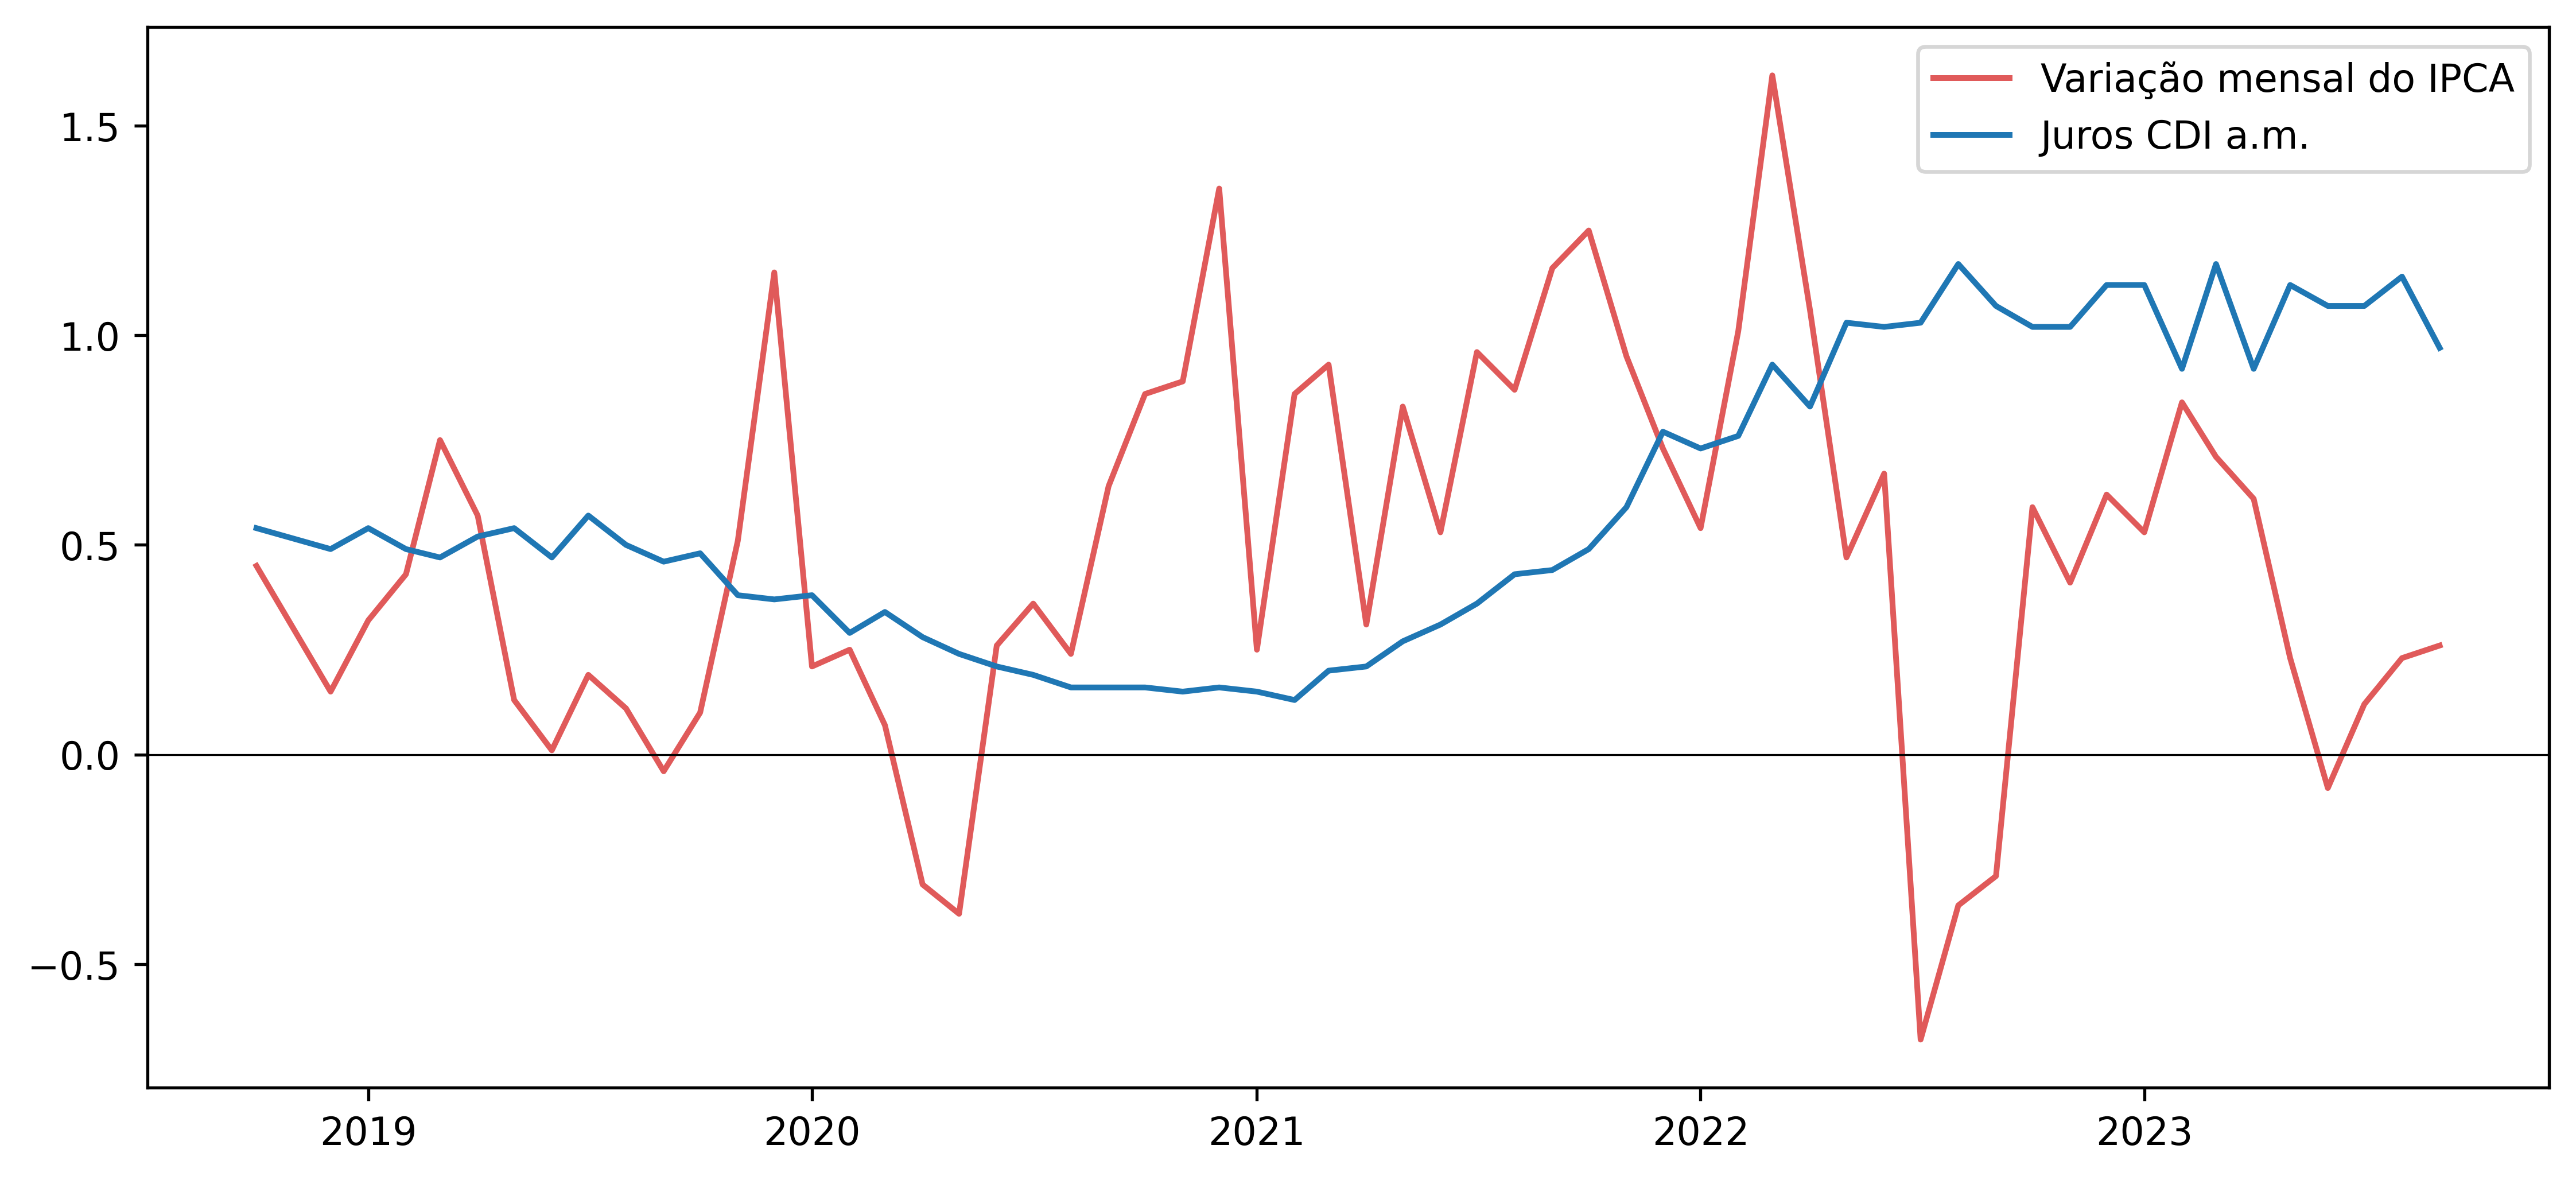

In [53]:
plt.plot(df.index, df.inflac, label='Variação mensal do IPCA', color='#e05a5a')
plt.plot(df.index, df.juros, label='Juros CDI a.m.')
plt.axhline(y = 0, color = 'black', linewidth=.5)
plt.legend()
plt.show()

## À primeira vista:

#### **Parecem não se relacionar quantitativamente**
"O comportamento de uma não tem nada a ver com o da outra"

#### **... nem qualitativamente**
"O que juros tem a ver com inflação?"

## Aplicando soma cumulativa...
#### O comportamento parece ficar mais parecido, aqui estamos vendo o efeito acumulado da inflação, taxa de juros, e taxa de juros descontada da inflação (rentabilidade real):

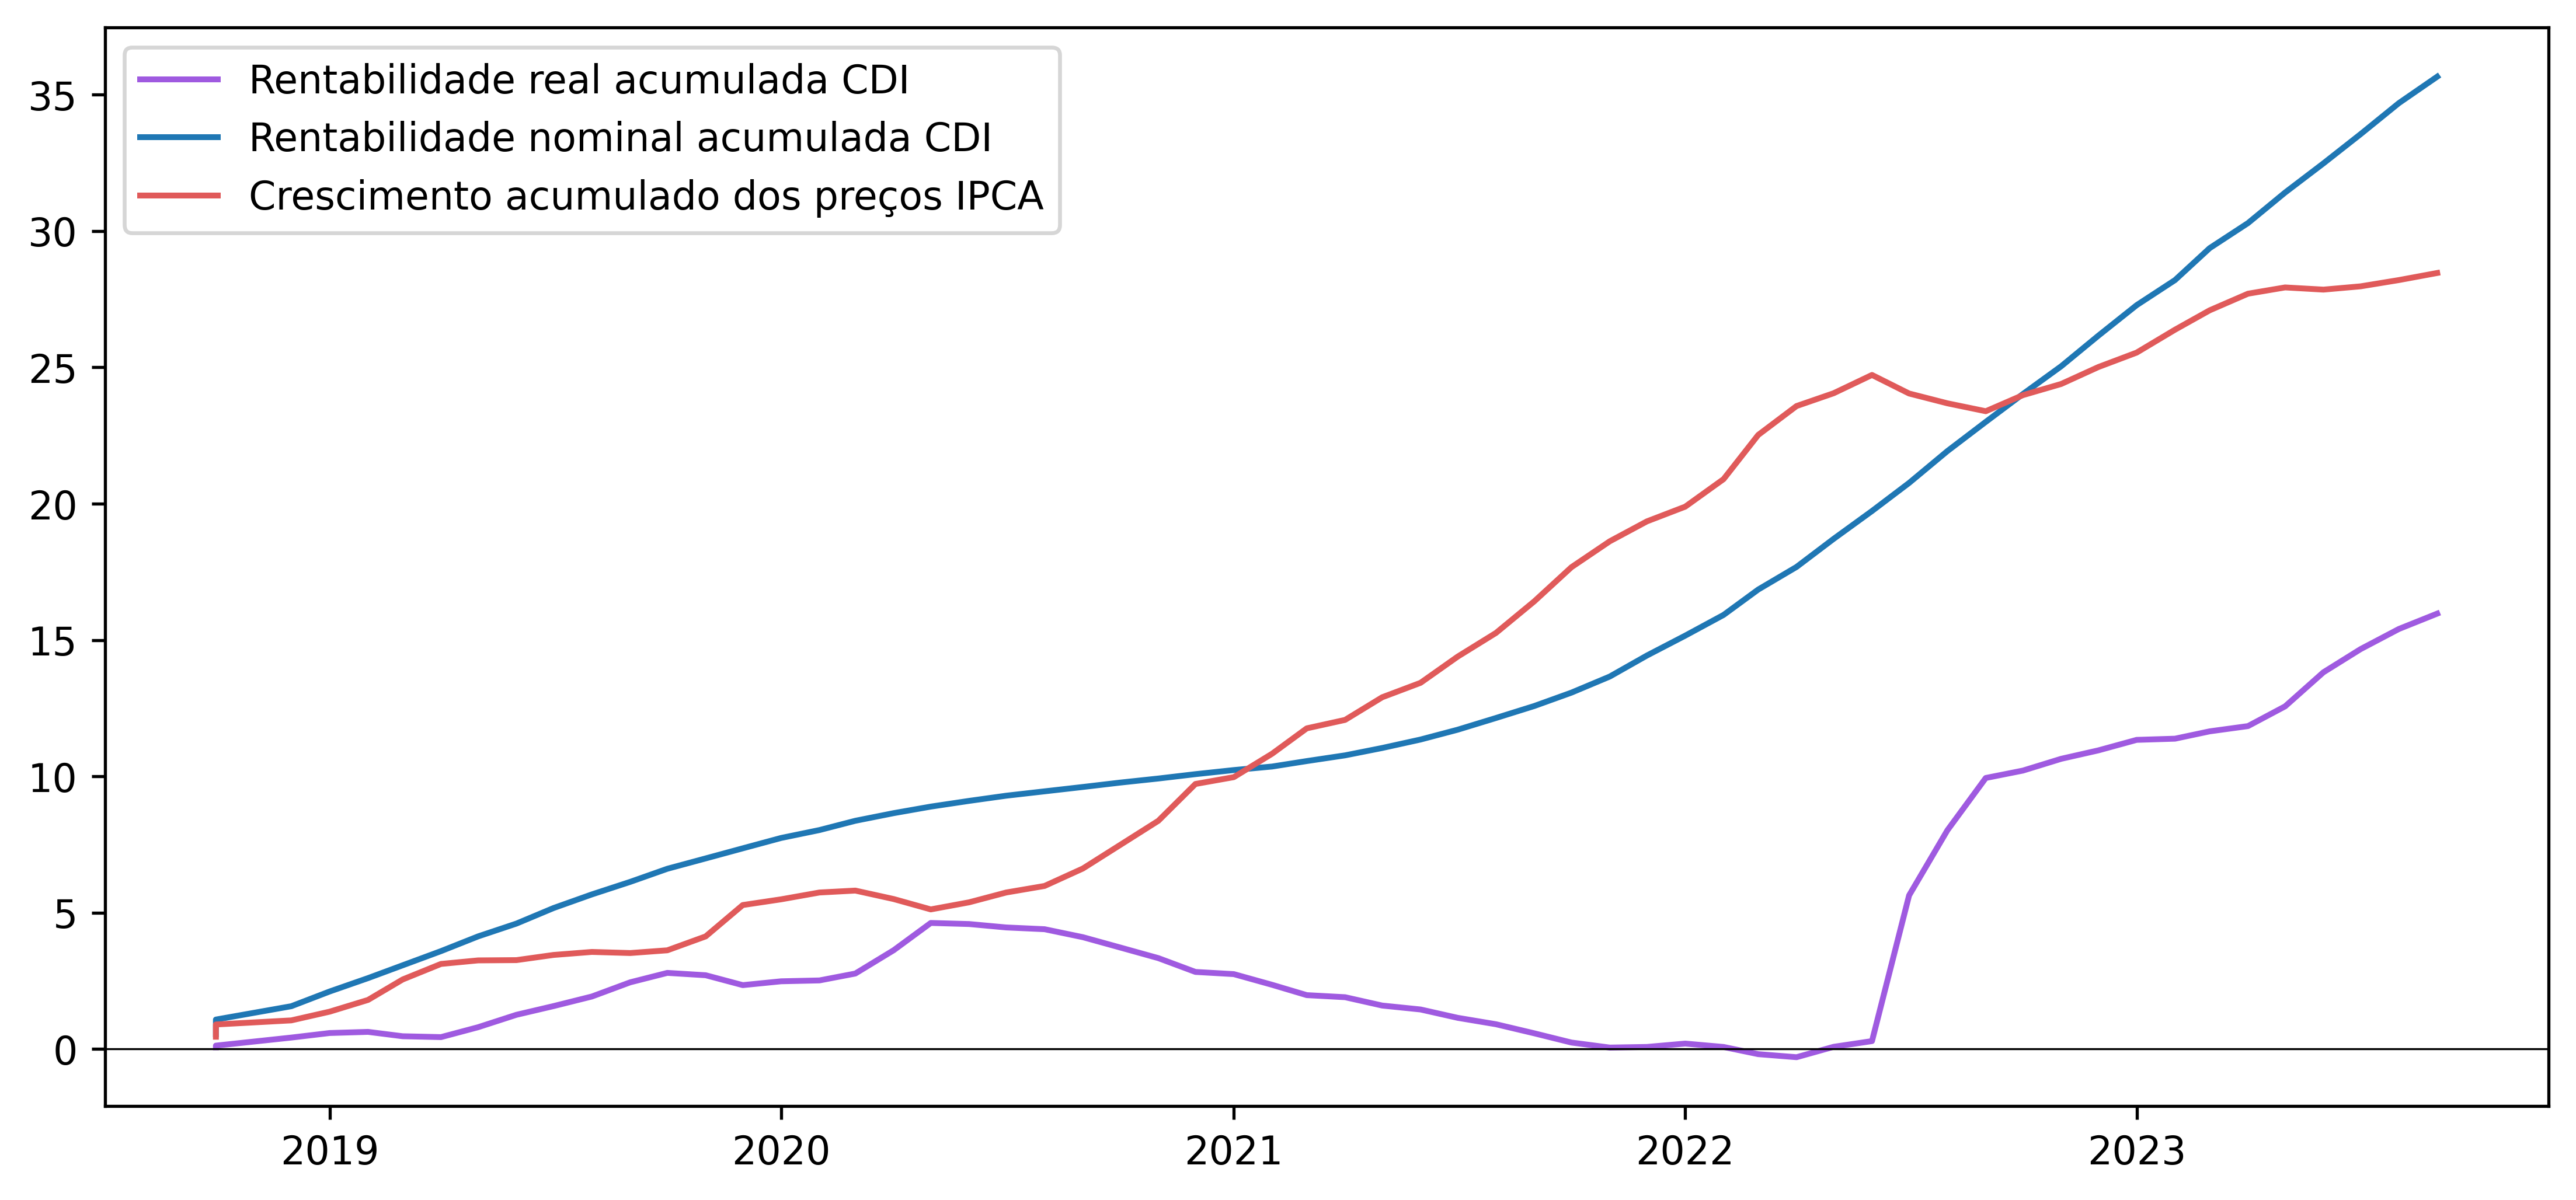

In [54]:
df['juros_real'] = ((1+df.juros)/(1+df.inflac)) -1

df['inflac_acm'] = df.inflac.cumsum()
df['juros_acm'] = df.juros.cumsum()
df['juros_real_acm'] = df.juros_real.cumsum()

plt.plot(df.index, df.juros_real_acm, label='Rentabilidade real acumulada CDI', color='#9f5ae0')
plt.plot(df.index, df.juros_acm, label='Rentabilidade nominal acumulada CDI')
plt.plot(df.index, df.inflac_acm, label='Crescimento acumulado dos preços IPCA', color='#e05a5a')
plt.axhline(y=0, color='black', linewidth=.5)
plt.legend()
plt.show()

## O nível de preços na verdade está bem relacionado com a taxa de juros

- O Conselho Monetário Nacional (CMN) usa a taxa de juros para controlar a inflação *do futuro*
    - Trata-se de um jogo de expectativas

- É esperado que a taxa de juros decidida hoje tenha efeito na inflação de aproximadamente 1 ano à frente

## Encontrando a melhor correlação
#### A partir do recorte que coletamos, a melhor correlação se encontra com 14 meses de defasagem, o que se aproxima bem do que era esperado:

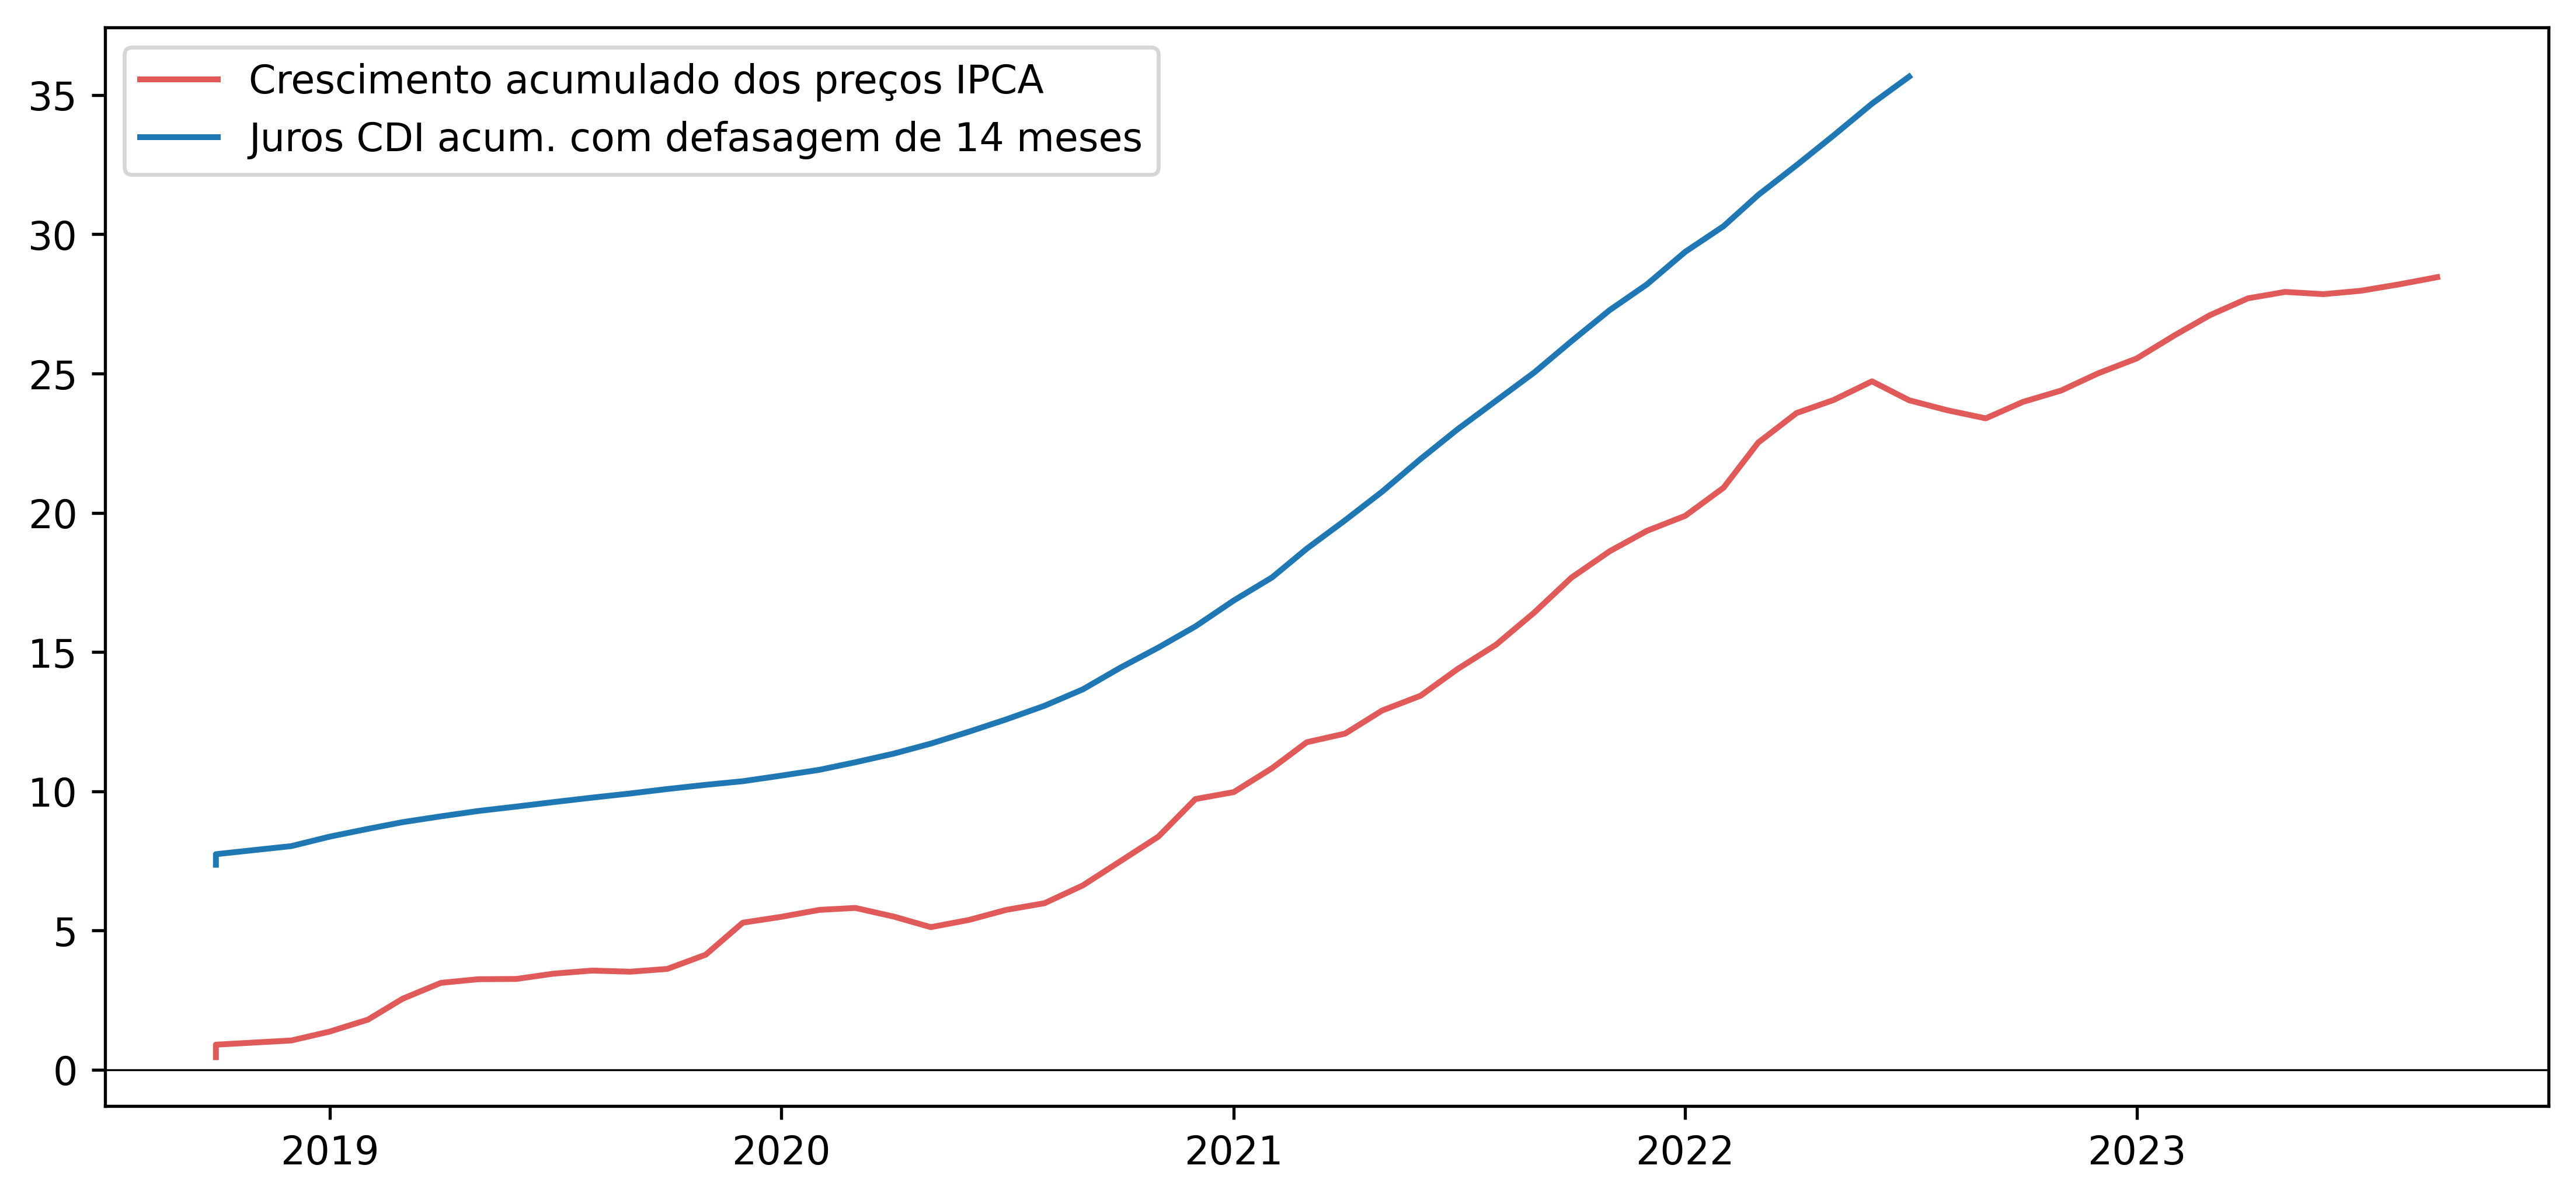

In [55]:
# Testando até 2 anos de defasagem, mês a mês
pd.options.mode.chained_assignment = None
bootstraps = df[['juros_acm', 'inflac_acm']]
for i in range(1, 25):
    bootstraps.loc[:,f'juros_acm_lag{i}'] = bootstraps.loc[:,'juros_acm'].shift(-i)

# Obtendo a defasagem que mostra a maior correlação com inflac_acm
lag_var = bootstraps.corr().loc['inflac_acm', bootstraps.columns != 'inflac_acm'].idxmax()

# Número de meses
lag_amount = search(r'\d+', lag_var)[0]

plt.plot(df.index, df.inflac_acm, label='Crescimento acumulado dos preços IPCA', color='#e05a5a')
plt.plot(df.index, bootstraps[lag_var], label=f'Juros CDI acum. com defasagem de {lag_amount} meses')
plt.axhline(y=0, color='black', linewidth=.5)
plt.legend()
plt.show()

## Agora podemos usar a taxa de juros CDI para prever a inflação IPCA
#### Vamos usar uma regressão simples com este formato:

<br><br><br>

$$
\pi_{(t=14)} = \alpha i_{(t=0)} + \beta
$$

<br><br><br>

Onde $\pi_{(t=14)}$ é a inflação 14 meses à frente, e $i_{(t=0)}$ é a taxa de juros no mês atual. $\alpha$ e $\beta$ são os coeficientes de inclinação e intercepto, respectivamente.

## Assim fica o ajuste do nosso modelo (nada mal!):

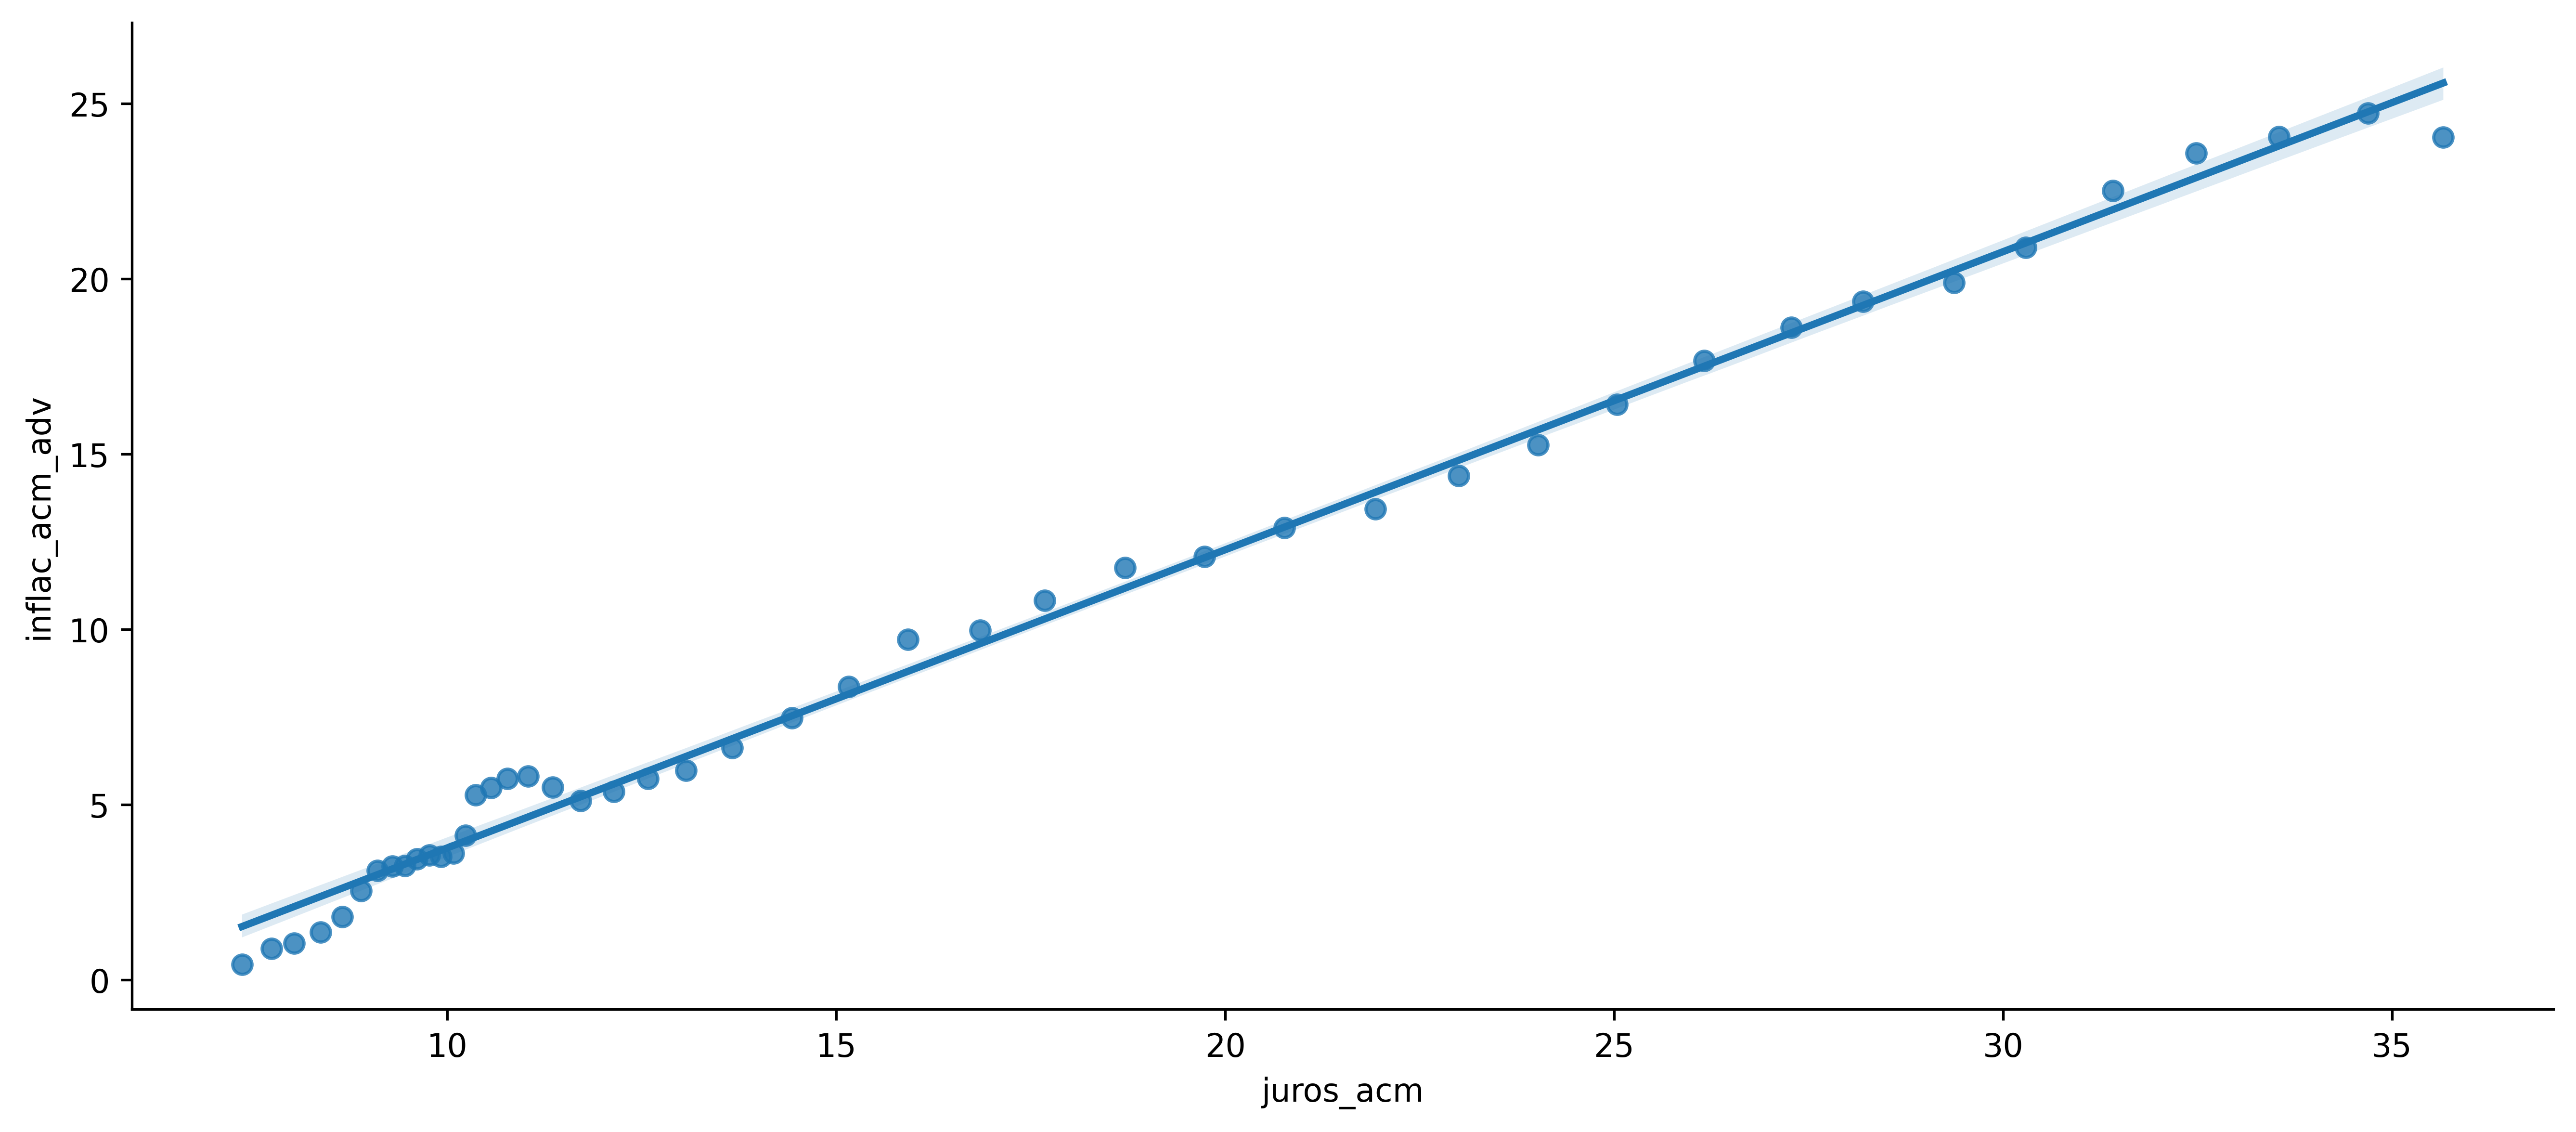

In [56]:
sns.lmplot(x='juros_acm', y='inflac_acm_adv', data=df, order=1, height=5, aspect=2.25)
plt.show()

## Também podemos fazer projeções do IPCA com ele!

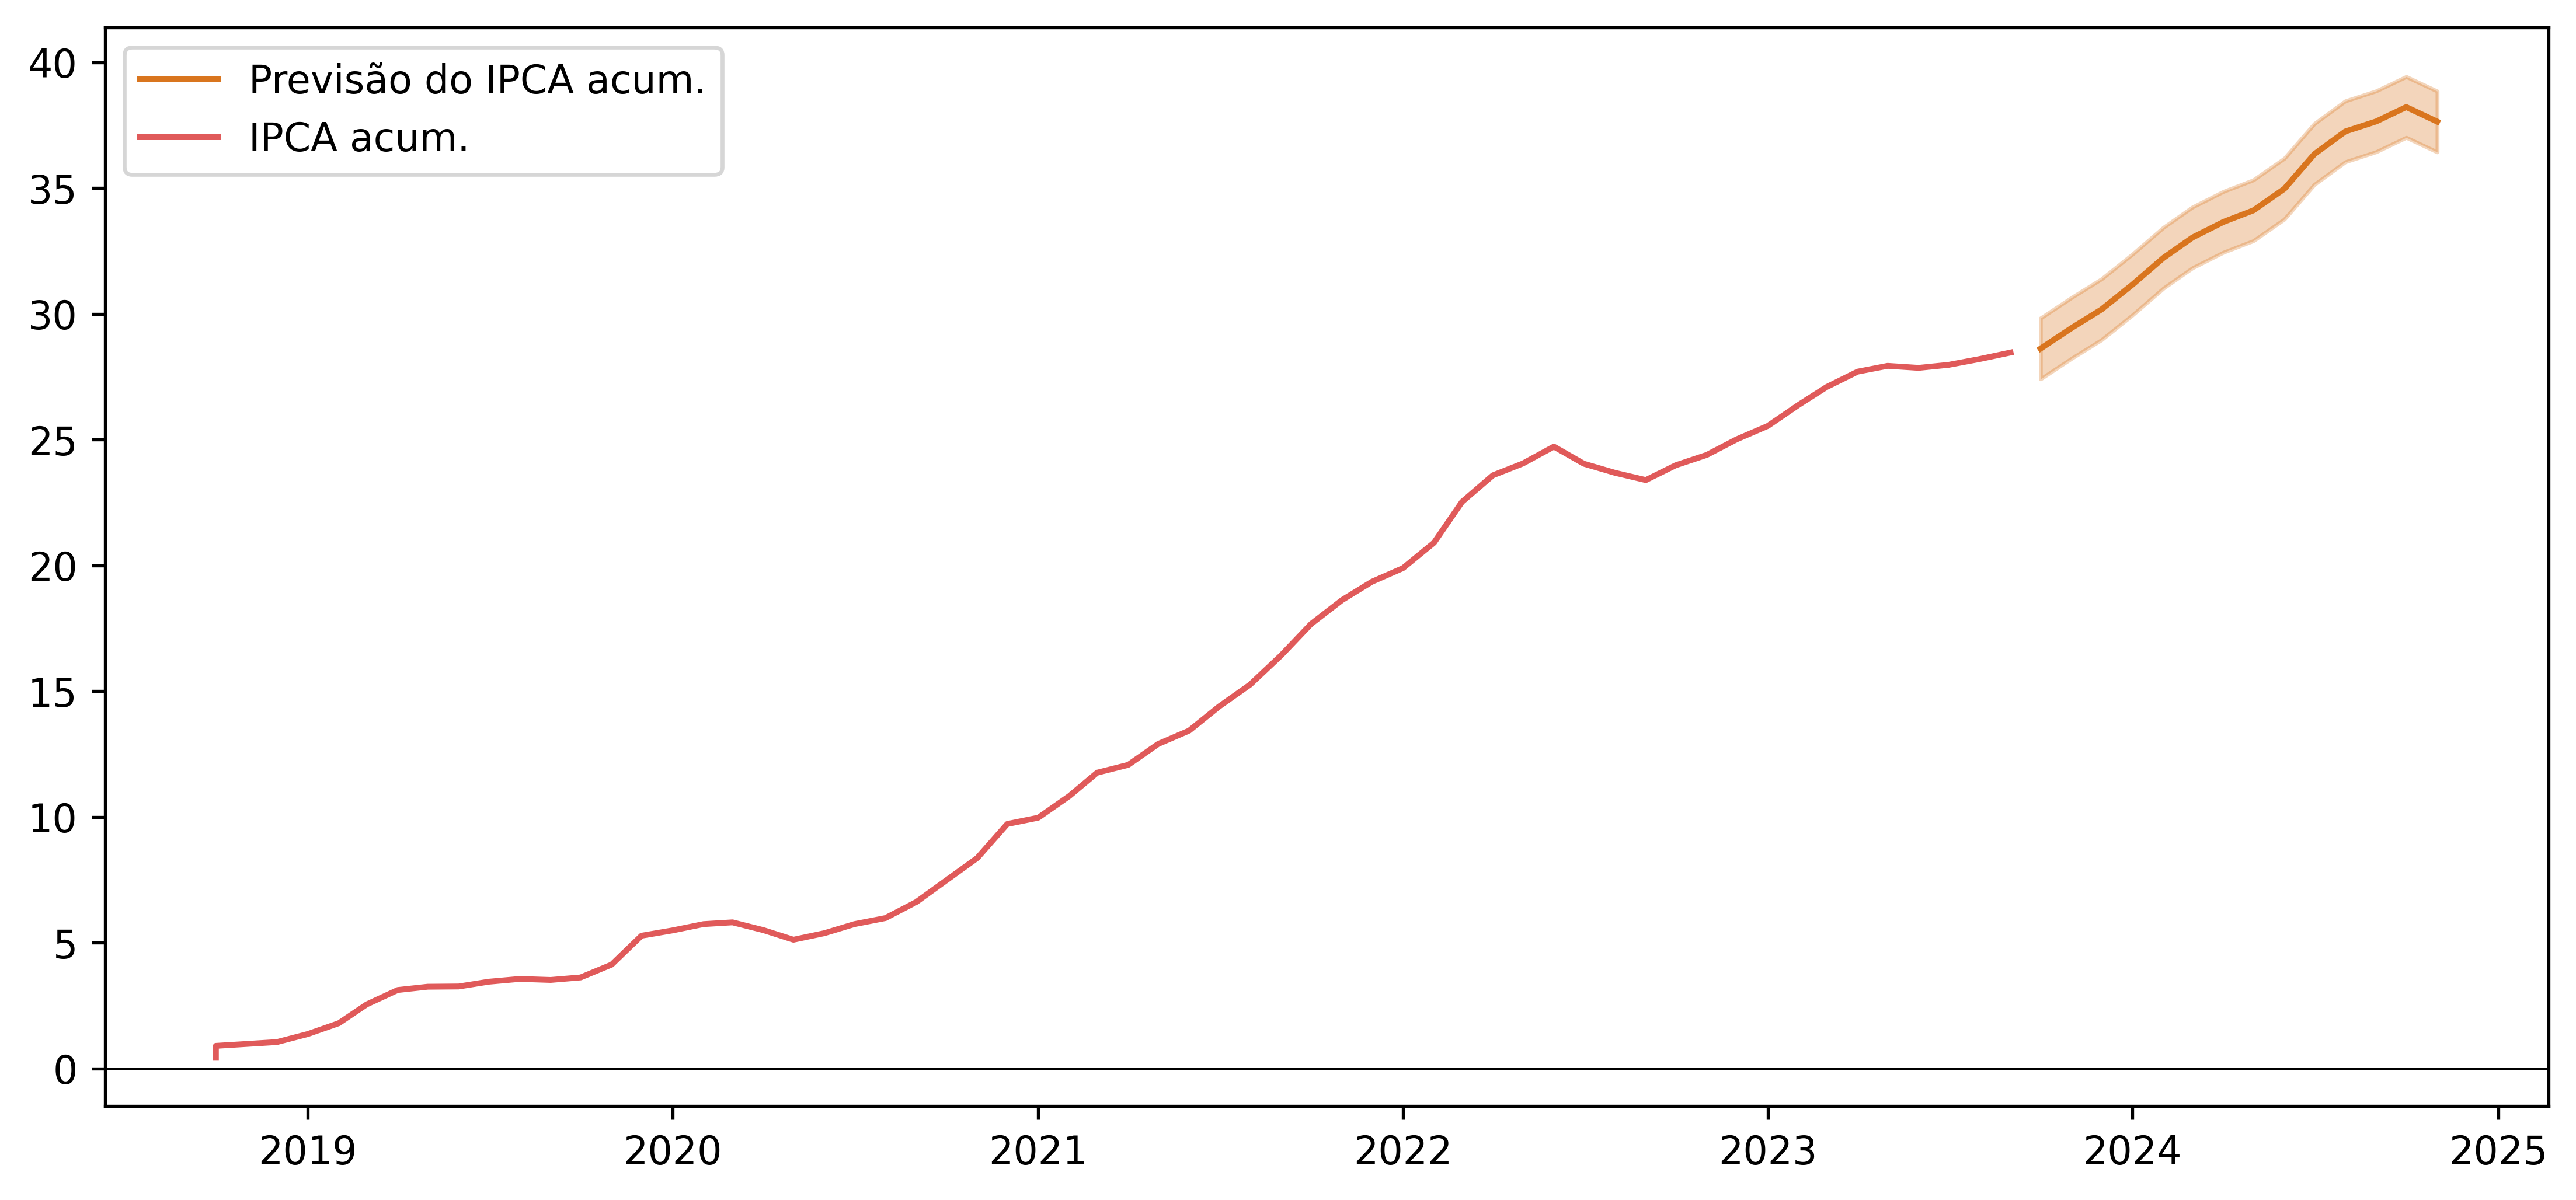

In [57]:
plt.plot(pred.index, pred['pred'], label=f'Previsão do IPCA acum.', color='#d9751e')
plt.plot(df.index, df['inflac_acm'], label='IPCA acum.', color='#e05a5a')
plt.fill_between(x=pred.index, y1=pred['neg_ic'], y2=pred['pos_ic'], alpha=.3, color='#d9751e')
plt.axhline(y=0, color='black', linewidth=.5)
plt.legend()
plt.show()

# Obrigado!

Para mais detalhes, [clique aqui](https://github.com/VFLins/Projects/blob/main/predict_ipca_with_cdi/taxa_de_juros_real.ipynb).

In [58]:
%%capture
!jupyter nbconvert slides.ipynb --to slides --no-input --output predict_ipca_with_cdi_presentation